In [2]:
from pprint import pprint
import pandas as pd
import os

import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display


In [5]:
# pylint: disable=trailing-whitespace
RESULT_DELIMETER = "T/V                N    NB     P     Q               Time                 Gflops"

def get_parameter_grid(data): 
    
    start = None
    for i, value in enumerate(data):  
        if "The following parameter values will be used:" in value: 
            start = i 
    
    parameter_grid = { }

    for i, line in enumerate(data[start::]): 
        line = line.strip()
        if "----------------" in line: 
            break 
        else: 
            if line != "": 
                # value.split(":")
                value = line.split(":")

                key = value[0].strip()
                value = value[1].strip()
                parameter_grid[key] = value
            
    return parameter_grid
            

def parse_data(data): 
    results = []
    for i, line in enumerate(data): 
        if RESULT_DELIMETER in line: 
            value = data[i+2]
            value = value.split()
            results.append(
                {"N": value[1], 
                "NB": value[2], 
                "P": value[3],
                "Q": value[4],
                "Time": value[5], 
                "Gflops": value[6],})
            
    return results


def make_table(data): 
    # command = "make logbruh"
    # data = os.popen(command).readlines()
    
    # parameter_grid = get_parameter_grid(data)        
    data = parse_data(data)
    # pprint(parameter_grid)
    df = pd.DataFrame(data, columns=["N","NB","P","Q","Time","Gflops"])
    # pprint(df)
    df["Time"] = df["Time"].astype(float)
    df["P"] = df["P"].astype(int)
    df["Q"] = df["Q"].astype(int)
    df["PQ"] = df["P"] * df["Q"]
    df["Time/mins"] = round(df["Time"]/60,2)

    df = df[["N","NB","P","Q","PQ","Time","Time/mins","Gflops"]]

    return df.sort_values(by=["Time"], ascending=[True])


def main(): 
    
    num_nodes = []
    gflops = []

    max_results = pd.DataFrame()

    dir_name = "results/HPL/cloud_runs/c2d-runs-145k-07-04-23"
    file_name = "results/HPL/cloud_runs/c2d-runs-145k-07-04-23/1Node54cores.out"
    
    for file_name in os.listdir(dir_name): 
        if file_name.endswith(".out"):     
            number_of_nodes = file_name[0:file_name.index("Node")]

            file_name = os.path.abspath(os.path.join(dir_name, file_name))

            # print(number_of_nodes)

            data = None 
            with open(file_name, "r") as file: 
                data = file.readlines()

            df = make_table(data)
            df["Gflops"] = df["Gflops"].astype(float)
            # print(f"Number of Nodes {number_of_nodes}")
            max_row = df.loc[df['Gflops'] == df['Gflops'].max()]
            # display(max_row)
            
            max_results = pd.concat([max_row, max_results], sort=False, ignore_index=True)
            

            num_nodes.append(int(number_of_nodes))
            gflops.append(df['Gflops'].max())
    max_results = max_results.sort_values(by="PQ")
    max_results["Nodes"] = max_results["PQ"]/54
    
    return num_nodes, gflops, max_results


In [6]:

# For the cloud results

num_nodes, gflops, max_results = main()


i = num_nodes.index(1)

node1_gflops = gflops[i]
ideal_speedup = [node1_gflops * value for value in num_nodes]

print(sorted(ideal_speedup))
print(sorted(gflops))
print(sorted(num_nodes))

fig, ax = plt.subplots()

sns.lineplot(num_nodes, gflops, label="Actual Speed", marker='o', ax=ax)
sns.lineplot(num_nodes, ideal_speedup, label="Ideal Speedup", linestyle="dashdot", ax=ax)

ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Gflops')
ax.set_title('Performance Comparison')

plt.legend()
plt.show()

max_results["speedup"] = max_results["Gflops"]/(max_results[max_results["Nodes"] == 1.0]["Gflops"].values[0])
display(max_results)

NotADirectoryError: [Errno 20] Not a directory: '/Users/rohanjain/Desktop/3rd_Year/Individual Project/Crambor/hpl/analysis/results/HPL/Hamilton/160kall_results.out'

[1.0, 2.0, 4.0, 8.0, 16.0] [2787.4, 5211.7, 9650.7, 16365.0, 24802.0]


/Users/rohanjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rohanjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


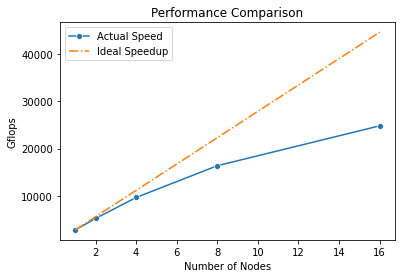

Nodes
1.0      2787.4
2.0      5211.7
4.0      9650.7
8.0     16365.0
16.0    24802.0
Name: Gflops, dtype: float64

In [21]:
# Hamilton Results
data = None
with open("/Users/rohanjain/Desktop/3rd_Year/Individual Project/Crambor/hpl/analysis/results/HPL/Hamilton/160kall_results.out", "r") as file:
    data = file.readlines()
df = make_table(data)
df["Nodes"] = (df["P"] * df["Q"])/128
df["Gflops"] = df["Gflops"].astype(float)

df = df.loc[df["N"] == "160000"]
max_gflops = df.groupby("Nodes")["Gflops"].max()


num_nodes = max_gflops.index.tolist()
gflops = max_gflops.values.tolist()

print(num_nodes, gflops)

i = num_nodes.index(1)

node1_gflops = gflops[i]
ideal_speedup = [node1_gflops * value for value in num_nodes]



fig, ax = plt.subplots()
# ax.set_xscale('log')
# ax.set_yscale('log')

sns.lineplot(num_nodes, gflops, label="Actual Speed", marker='o', ax=ax)
sns.lineplot(num_nodes, ideal_speedup, label="Ideal Speedup", linestyle="dashdot", ax=ax)

ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Gflops')
ax.set_title('Performance Comparison')

plt.legend()
plt.show()

display(max_gflops)


In [24]:
all_max_results = pd.DataFrame()

max_gflops = df.groupby("Nodes")["Gflops"].max()

# Initialize an empty list to store the rows with the maximum 'Gflops' value for each group

# Iterate over the groups and append the rows that correspond to the maximum 'Gflops' value to the list
for nodes, gflops in max_gflops.iteritems():
    # Find the row with the maximum 'Gflops' value for the current group
    idx = df.loc[df["Nodes"] == nodes, "Gflops"].idxmax()
    # Append the row to the list

    max_row = df.loc[[idx], :]
    all_max_results = pd.concat([max_row, all_max_results], sort=False, ignore_index=True)

all_max_results["speedup"] = all_max_results["Gflops"]/node1_gflops
all_max_results["speedup_percentage"] = all_max_results["speedup"]/all_max_results["Nodes"]


display(all_max_results.sort_values(by="Nodes"))
# Concatenate the rows into a single DataFrame

,N,NB,P,Q,PQ,Time,Time/mins,Gflops,Nodes,speedup,speedup_percentage
4,160000,252,8,16,128,979.65,16.33,2787.4,1.0,1.000000,1.000000
3,160000,252,8,32,256,523.95,8.73,5211.7,2.0,1.869735,0.934868
2,160000,252,16,32,512,282.95,4.72,9650.7,4.0,3.462259,0.865565
1,160000,252,8,128,1024,166.86,2.78,16365.0,8.0,5.871063,0.733883
0,160000,252,8,256,2048,110.10,1.84,24802.0,16.0,8.897898,0.556119
